In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
from pathlib import Path
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, r2_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [4]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

In [6]:
def perform_eda(data, target_column=None, num_bins=20):
    """
    Performs exploratory data analysis (EDA) on a dataset.

    Args:
        data (pd.DataFrame): The dataset to analyze.
        target_column (str, optional): Name of the target column for analysis. Defaults to None.
        num_bins (int, optional): Number of bins for histograms. Defaults to 20.

    Returns:
        None: Displays EDA results including statistics, distributions, and visualizations.
    """
    print("===== EDA Summary =====\n")
    
    # 1. Basic Information
    print("1. Basic Information:")
    print(f"Shape of dataset: {data.shape}")
    print("\nData Types:\n", data.dtypes)
    print("\nSample Data:\n", data.head(), "\n")

    # 2. Check for Missing Values
    print("2. Missing Values:")
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0], "\n")
    else:
        print("No missing values detected.\n")
    
    # 3. Summary Statistics
    print("3. Summary Statistics:")
    print(data.describe(include='all'), "\n")

    # 4. Target Column Analysis
    if target_column and target_column in data.columns:
        print(f"4. Target Column Analysis: {target_column}")
        if data[target_column].dtype == 'object':
            # If the target column is categorical
            print("\nValue Counts:\n", data[target_column].value_counts(), "\n")
            try:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=target_column, data=data, order=data[target_column].value_counts().index)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()  # Adjust layout to prevent overlap
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
        elif data[target_column].dtype in ['int64', 'float64']:
            # If the target column is numeric (int64 or float64)
            try:
                sns.histplot(data[target_column], kde=True, bins=num_bins)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
    else:
        print("No target column specified or invalid target column.")

    # 5. Visualizations for Numeric Features
    print("5. Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        try:
            data[numeric_columns].hist(figsize=(12, 8), bins=num_bins)
            plt.suptitle("Numeric Feature Distributions", fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting numeric distributions: {e}")
    else:
        print("No numeric column found to plot")

    # 6. Correlation Heatmap
    print("6. Correlation Analysis:")
    if len(numeric_columns) > 0:
        try:
            correlation_matrix = data[numeric_columns].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap: {e}")
    else:
        print("No numeric column found to perform correlation")

    # 7. Categorical Feature Analysis
    print("7. Categorical Features:")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            try:
                print(f"\nValue Counts for {column}:\n", data[column].value_counts())
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=data, order=data[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {e}")
    else:
        print("No categorical features found.")

    print("\n===== EDA Complete =====")


===== EDA Summary =====

1. Basic Information:
Shape of dataset: (4250, 20)

Data Types:
 state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

Sample Data:
   state  account_length      area_code international_plan voi

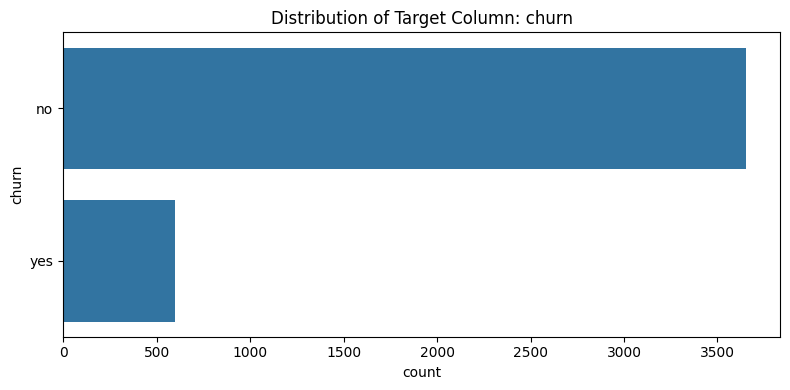

5. Numeric Feature Distributions:


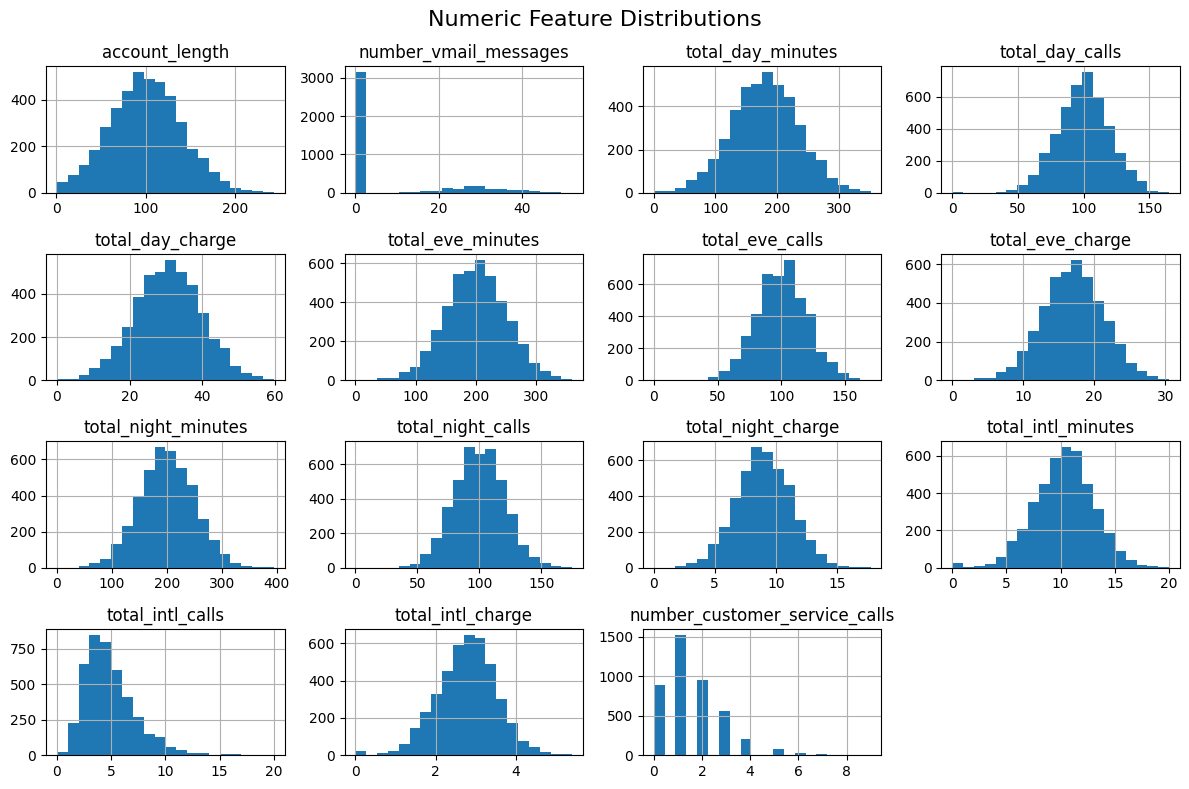

6. Correlation Analysis:


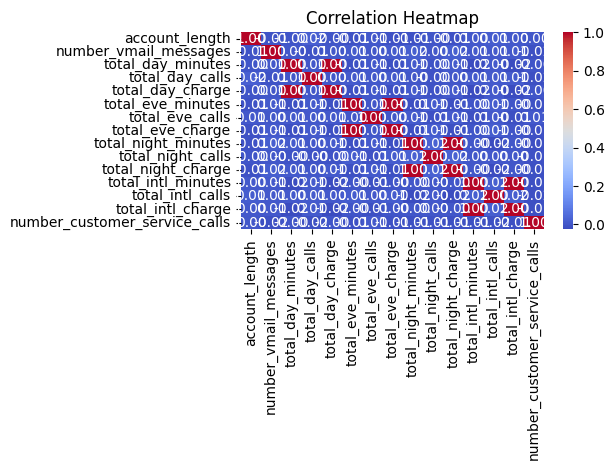

7. Categorical Features:

Value Counts for state:
 state
WV    139
MN    108
ID    106
AL    101
VA    100
OR     99
TX     98
UT     97
NY     96
NJ     96
OH     95
WY     95
WI     94
MA     89
ME     89
CT     88
RI     87
KS     87
MI     87
VT     86
MD     86
KY     85
IN     83
NV     83
MS     82
WA     80
MO     80
CO     80
NC     80
MT     80
DE     80
IL     79
TN     79
NH     78
OK     78
NM     78
AZ     77
HI     77
FL     76
SD     75
NE     73
SC     72
DC     72
AR     71
LA     69
ND     67
PA     67
GA     64
IA     62
AK     61
CA     39
Name: count, dtype: int64


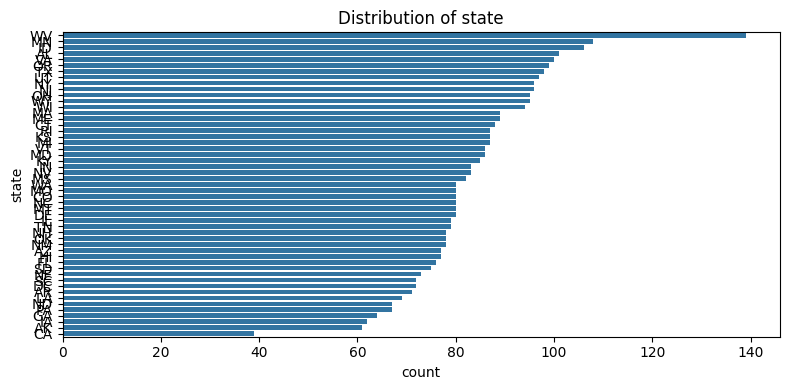


Value Counts for area_code:
 area_code
area_code_415    2108
area_code_408    1086
area_code_510    1056
Name: count, dtype: int64


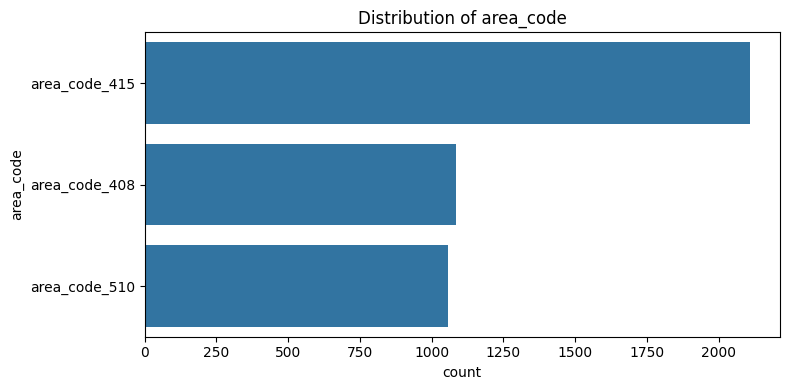


Value Counts for international_plan:
 international_plan
no     3854
yes     396
Name: count, dtype: int64


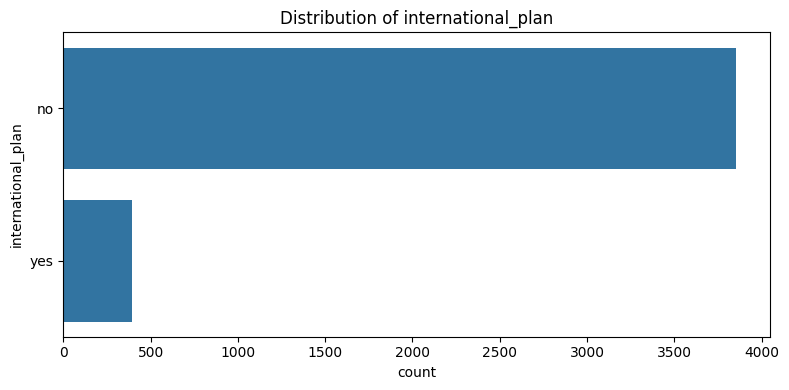


Value Counts for voice_mail_plan:
 voice_mail_plan
no     3138
yes    1112
Name: count, dtype: int64


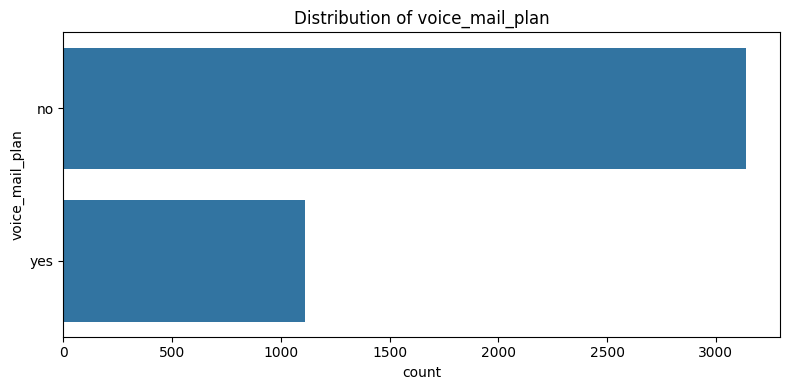


Value Counts for churn:
 churn
no     3652
yes     598
Name: count, dtype: int64


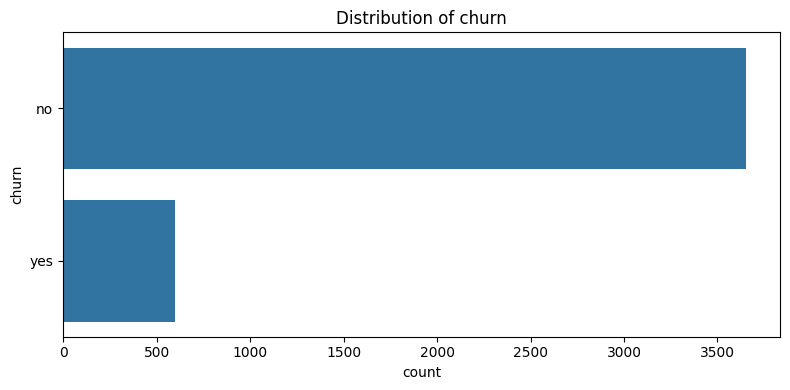


===== EDA Complete =====


In [7]:
perform_eda(train, target_column='churn')

===== EDA Summary =====

1. Basic Information:
Shape of dataset: (750, 20)

Data Types:
 id                                 int64
state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
dtype: object

Sample Data:
    id state  account_length      area_code international_plan 

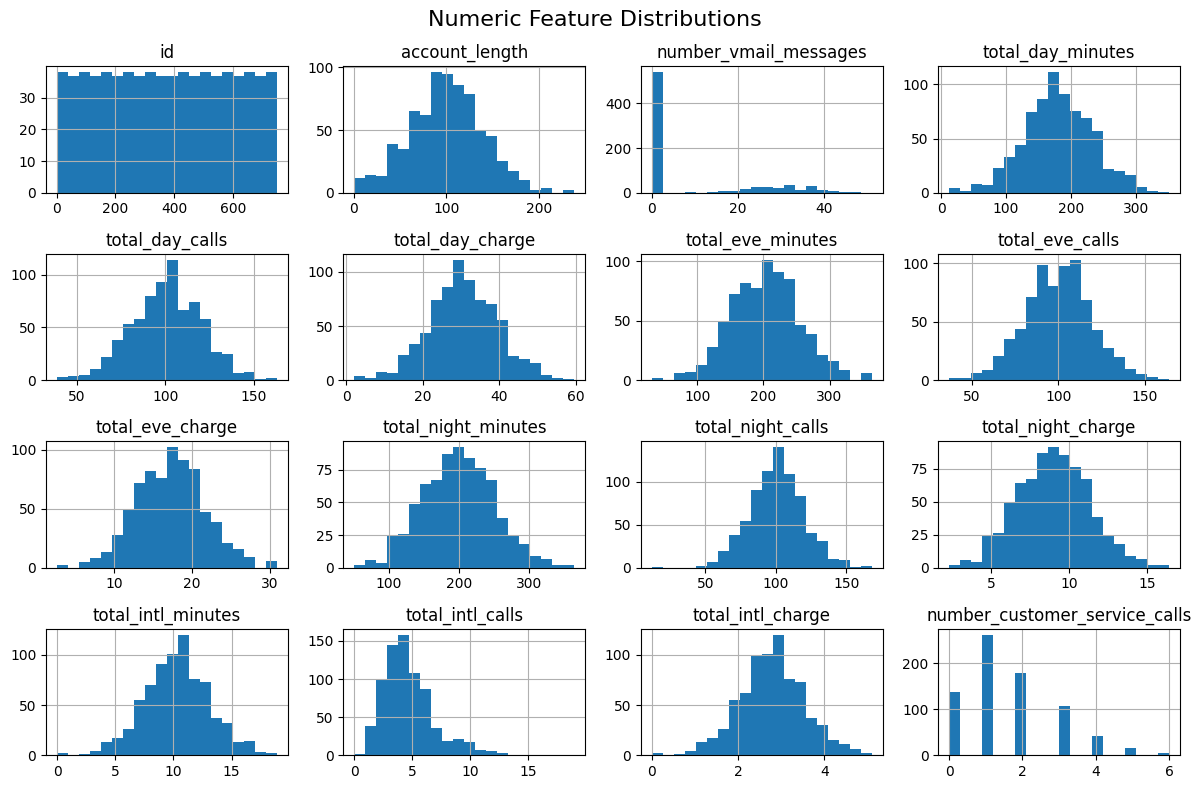

6. Correlation Analysis:


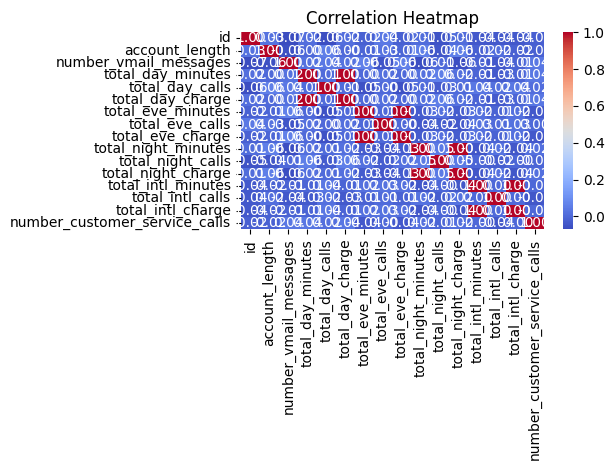

7. Categorical Features:

Value Counts for state:
 state
AL    23
ND    21
AR    21
OH    21
WY    20
SC    19
MT    19
WV    19
GA    19
NY    18
TX    18
WA    18
VA    18
MN    17
MS    17
NH    17
DC    16
NJ    16
CO    16
MI    16
MD    16
VT    15
NE    15
IN    15
OR    15
UT    15
KY    14
MA    14
DE    14
FL    14
ME    14
NM    13
LA    13
ID    13
MO    13
CA    13
RI    12
AZ    12
WI    12
KS    12
OK    12
AK    11
CT    11
NC    11
TN    10
SD    10
PA    10
HI     9
IL     9
IA     7
NV     7
Name: count, dtype: int64


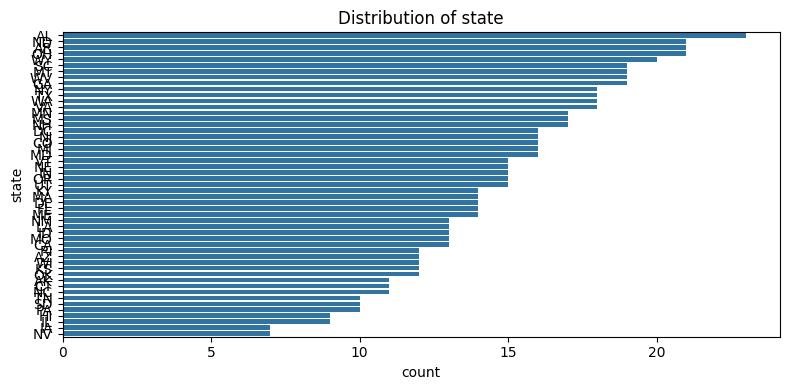


Value Counts for area_code:
 area_code
area_code_415    387
area_code_510    190
area_code_408    173
Name: count, dtype: int64


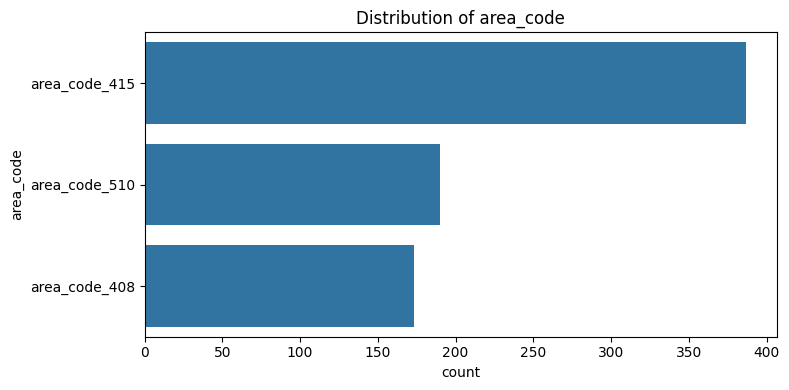


Value Counts for international_plan:
 international_plan
no     673
yes     77
Name: count, dtype: int64


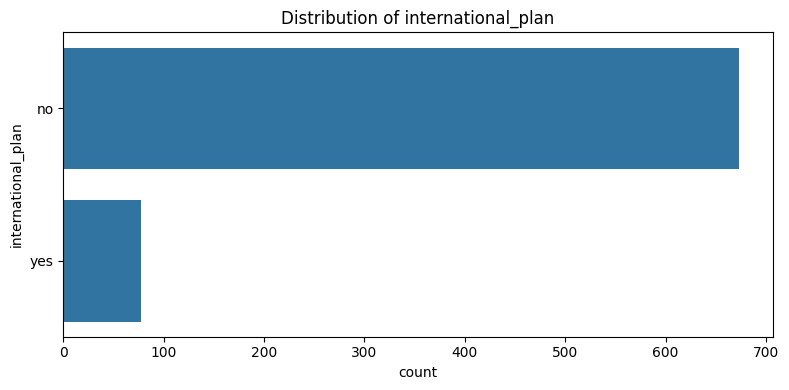


Value Counts for voice_mail_plan:
 voice_mail_plan
no     539
yes    211
Name: count, dtype: int64


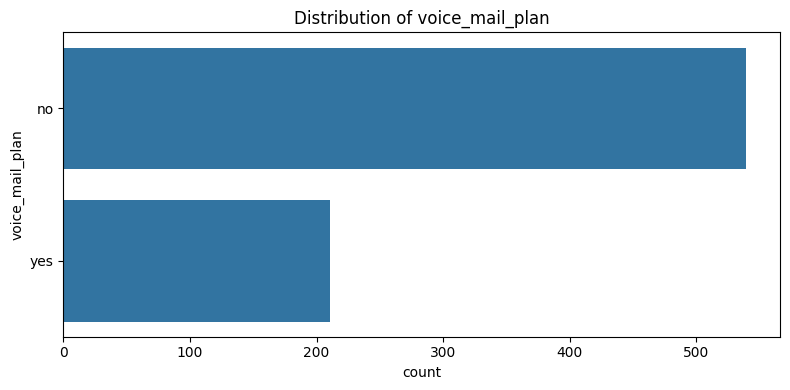


===== EDA Complete =====


In [8]:
perform_eda(test, target_column='churn')

In [9]:
# create copies of the data
train_cpy = train.copy()
test_cpy = test.copy()

In [10]:
# Identify categorical columns
train_categ = train_cpy.select_dtypes(include=['object', 'category']).columns
test_categ = test_cpy.select_dtypes(include=['object', 'category']).columns

# Apply LabelEncoder to each categorical column consistently
label_encoders = {}
for col in train_categ:
    # Create a LabelEncoder for each column and fit it on the train set
    label_encoders[col] = LabelEncoder()
    train_cpy[col] = label_encoders[col].fit_transform(train_cpy[col])

    # Transform the test set using the same encoder
    if col in test_categ:  # Ensure column exists in the test set
        test_cpy[col] = label_encoders[col].transform(test_cpy[col])

<Axes: xlabel='churn'>

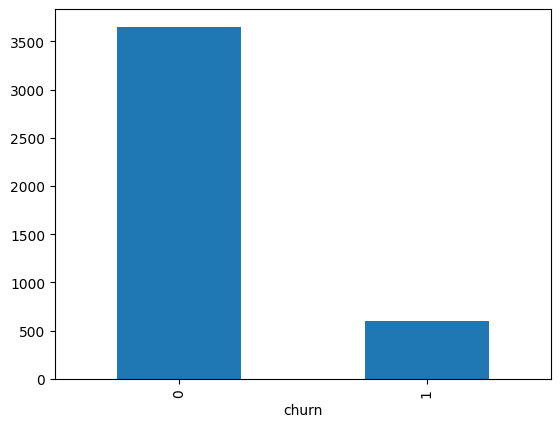

In [21]:
# checking the balance of the dataset
train_cpy['churn'].value_counts().plot.bar()

below is a code to drop unnecessary columns by finding their correlation with the target variable. this is to reduce noise and reduce the columns as well. the columns below the average correlation will be dropped and applied to the test set as well. 

In [11]:
# Step 1: Calculate correlations in train_cpy with 'churn'
correlation_with_churn = train_cpy.corr()['churn'].drop('churn').sort_values(ascending=False)

# Step 2: Set a threshold for correlation
threshold = correlation_with_churn.abs().mean()  # Use the mean absolute correlation as the threshold

# Identify columns to keep based on the threshold
columns_to_keep = correlation_with_churn[correlation_with_churn.abs() >= threshold].index.tolist()

# Include the target column 'churn' in train data
columns_to_keep.append('churn')

# Step 3: Filter train_cpy and test_cpy
train_cpy = train_cpy[columns_to_keep]
test_cpy = test_cpy[columns_to_keep[:-1]]  # Exclude 'churn' for the test set

# Output results
print(f"Columns retained in train_cpy: {list(train_cpy.columns)}")
print(f"Columns retained in test_cpy: {list(test_cpy.columns)}")


Columns retained in train_cpy: ['international_plan', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 'number_vmail_messages', 'voice_mail_plan', 'churn']
Columns retained in test_cpy: ['international_plan', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 'number_vmail_messages', 'voice_mail_plan']


In [13]:
train_cpy.head()

,international_plan,number_customer_service_calls,total_day_minutes,total_day_charge,number_vmail_messages,voice_mail_plan,churn
0,0,1,161.6,27.47,26,1,0
1,0,0,243.4,41.38,0,0,0
2,1,2,299.4,50.90,0,0,0
3,1,3,166.7,28.34,0,0,0
4,0,3,218.2,37.09,24,1,0


In [14]:
test_cpy.head()

,international_plan,number_customer_service_calls,total_day_minutes,total_day_charge,number_vmail_messages,voice_mail_plan
0,0,1,265.1,45.07,25,1
1,1,0,223.4,37.98,0,0
2,0,4,120.7,20.52,0,0
3,0,3,190.7,32.42,0,0
4,0,3,124.3,21.13,0,0


In [15]:
# divide into target and predictors
X = train_cpy.drop('churn', axis=1)
y = train_cpy['churn']

In [16]:
# standardising the columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_cpy)

In [17]:
# dividing the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.33,random_state=42)

calling and training a model

In [18]:
# logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# predicting the model
y_pred = lr.predict(X_test)

# measure the effectiveness of the model
accuracy = accuracy_score(y_test, y_pred) # accuracy score
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.86
F1 Score: 0.82
Confusion Matrix:
[[1171   20]
 [ 179   33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1191
           1       0.62      0.16      0.25       212

    accuracy                           0.86      1403
   macro avg       0.75      0.57      0.59      1403
weighted avg       0.83      0.86      0.82      1403



the model has a 
1. True Negative of 1171 - Correctly predicted negative outcomes. In this case it correctly predicted 'no churn' cases
2. False Positive of 20 - Wrongly predicted 20 positive outcomes. In this case it was wrong when it predicted 'churn' cases
3. True Positive of 33 - It correctly predicted 33 instances of positive cases. In this case it was correct 33 times when it predicted 'church'cases
4. False Negative of 179 - It wrongly predicted 179 cases of negative cases. In this case it was wrong 179 times when it predicted 'no churn' cases

In [22]:
# using another model -- random forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # Initialize the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Predict the target values using the test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print("Classification Report:")
print(class_report_rf)

Accuracy: 0.87
F1 Score: 0.82
Confusion Matrix:
[[1115   76]
 [ 100  112]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1191
           1       0.60      0.53      0.56       212

    accuracy                           0.87      1403
   macro avg       0.76      0.73      0.74      1403
weighted avg       0.87      0.87      0.87      1403



notes:

In [24]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state = 42) 

X_smote, y_smote = smote.fit_resample(X_train,y_train)

In [25]:
# logistic regression
lr_smote = LogisticRegression()
lr_smote.fit(X_smote, y_smote)

# predicting the model
y_pred = lr_smote.predict(X_test)

# measure the effectiveness of the model
accuracy = accuracy_score(y_test, y_pred) # accuracy score
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.76
F1 Score: 0.79
Confusion Matrix:
[[907 284]
 [ 56 156]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1191
           1       0.35      0.74      0.48       212

    accuracy                           0.76      1403
   macro avg       0.65      0.75      0.66      1403
weighted avg       0.85      0.76      0.79      1403



In [26]:
# using another model -- random forest
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42) # Initialize the Random Forest classifier
rf_smote.fit(X_smote, y_smote)

# Predict the target values using the test data
y_pred_rf = rf_smote.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print("Classification Report:")
print(class_report_rf)

Accuracy: 0.83
F1 Score: 0.79
Confusion Matrix:
[[1013  178]
 [  59  153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      1191
           1       0.46      0.72      0.56       212

    accuracy                           0.83      1403
   macro avg       0.70      0.79      0.73      1403
weighted avg       0.87      0.83      0.85      1403



# TO NOTE
the models worked better without using the smote technique